<a href="https://colab.research.google.com/github/markusgoeswein/ProbML_Conformal/blob/main/ProbML_Conformal_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Worked Example: Conformal Prediction Sets with Score Method, APS, RAPS

This notebook contains the code used to generate the prediction sets and figures for my seminar report on conformal inference. The data and some portions of the code were adopted from Angelopolous and Bates(2022).
This notebook roughly follows this structure:


1.   Data and Library Import
2.   Score Method
3.   Adaptive Prediction Sets (APS)
4.   Regularised Adaptive Prediction Sets (RAPS)
5.   Example


## Import libraries and data

In [209]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
!pip install -U --no-cache-dir gdown --pre

In [210]:
# Load cached data
if not os.path.exists('../data'):
    os.system('gdown 1h7S6N_Rx7gdfO3ZunzErZy6H7620EbZK -O ../data.tar.gz')
    os.system('tar -xf ../data.tar.gz -C ../')
    os.system('rm ../data.tar.gz')
if not os.path.exists('../data/imagenet/human_readable_labels.json'):
    !wget -nv -O ../data/imagenet/human_readable_labels.json -L https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json

data = np.load('../data/imagenet/imagenet-resnet152.npz')
example_paths = os.listdir('../data/imagenet/examples')
smx = data['smx']
labels = data['labels'].astype(int)

In [211]:
data = np.load('../data/imagenet/imagenet-resnet152.npz')
example_paths = os.listdir('../data/imagenet/examples')
smx = data['smx']
labels = data['labels'].astype(int)

In [212]:
# Problem setup
n=1000 # number of calibration points
alpha = 0.1 # 1-alpha is the desired coverage

In [213]:
# Split the softmax scores into calibration and validation sets (save the shuffling)
rng = np.random.default_rng(42)
idx = np.array([1] * n + [0] * (smx.shape[0]-n)) > 0
rng.shuffle(idx)
cal_smx, val_smx = smx[idx,:], smx[~idx,:]
cal_labels, val_labels = labels[idx], labels[~idx]

In [214]:
with open('../data/imagenet/human_readable_labels.json') as f:
    label_strings = np.array(json.load(f))

Extract indices of loaded images.

In [215]:
split_arr = np.char.split(np.array(example_paths), ".")
split_arr[:5]

array([list(['40069', 'jpeg']), list(['23012', 'jpeg']),
       list(['21491', 'jpeg']), list(['2449', 'jpeg']),
       list(['27478', 'jpeg'])], dtype=object)

In [216]:
first_elem = [elem[0] for elem in split_arr]
first_elem[:5]

['40069', '23012', '21491', '2449', '27478']

In [217]:
example_idx = [int(elem) for elem in first_elem]
example_idx[:5]

[40069, 23012, 21491, 2449, 27478]

## Score Method

### Calibration Step and Construction of Prediction Sets

In [218]:
# 1: get conformal scores. n = calib_Y.shape[0]
cal_scores_sm = 1-cal_smx[np.arange(n),cal_labels]

# 2: get adjusted quantile
q_level = np.ceil((n+1)*(1-alpha))/n
qhat_sm = np.quantile(cal_scores_sm, q_level, method='higher')

# 3: form prediction sets
prediction_sets_sm = val_smx >= (1-qhat_sm)

In [219]:
empirical_coverage_sm = prediction_sets_sm[
    np.arange(prediction_sets_sm.shape[0]), val_labels
].mean()
print(f"The empirical coverage is: {empirical_coverage_sm}")

The empirical coverage is: 0.8903877551020408


### Score Method: Plot of Set Sizes

In [220]:
# Extract the set sizes
len_prediction_sets_sm = prediction_sets_sm.sum(axis = 1)

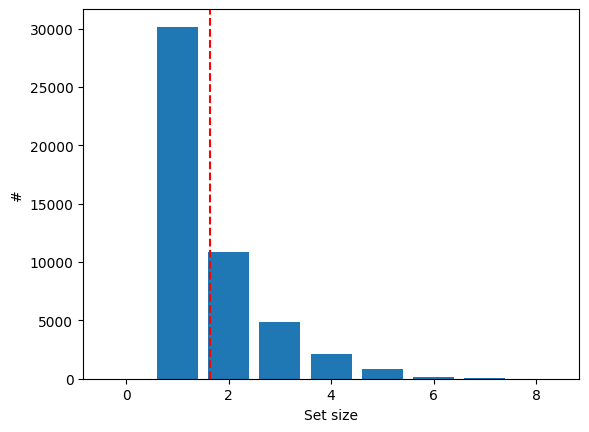

In [221]:
# Plot the set sizes in a histogram
tmp = np.unique(len_prediction_sets_sm, return_counts = True)
avg_set_size_sm = (tmp[0]*tmp[1]).sum() / tmp[1].sum()
plt.bar(tmp[0], tmp[1])
plt.axvline(x = avg_set_size_sm, color = "red", linestyle = "--")
plt.xlabel("Set size")
plt.ylabel("#")
plt.savefig("SM_set_sizes")

### Score Method: Histogram of Calibration Scores

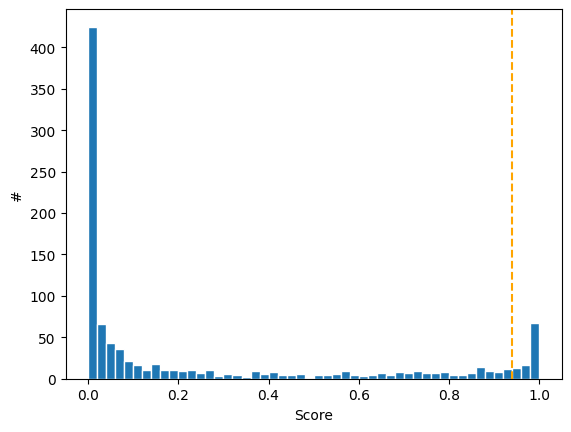

In [222]:
plt.hist(cal_scores_sm, bins = 50, ec = "white")
plt.axvline(qhat_sm, color = "orange", linestyle = "--")
# plt.axvline(np.mean(cal_scores), color = "darkgreen")
plt.xlabel("Score")
plt.ylabel("#")
plt.savefig("SM_cal_scores.png")
plt.show()

## APS

### Calibration Step and Construction of Prediction Sets (non-random and random)

In [223]:
# Get scores. calib_X.shape[0] == calib_Y.shape[0] == n
disallow_zero_sets = False

# Sort the softmax output in descending order
cal_pi = cal_smx.argsort(1)[:, ::-1]
cal_srt = np.take_along_axis(cal_smx, cal_pi, axis=1)
cal_srt_cumsum = np.take_along_axis(cal_smx, cal_pi, axis=1).cumsum(axis=1)

cal_L = np.where(cal_pi == cal_labels[:,None])[1]

#non-random calibration scores
cal_scores_aps = np.take_along_axis(cal_srt_cumsum, cal_pi.argsort(axis=1), axis=1)[
      range(n), cal_labels
]

#random calibration scores
cal_scores_aps_rand = cal_srt_cumsum[np.arange(n),cal_L] - rng.uniform(0,1,n)*cal_srt[np.arange(n),cal_L]

# Get the score quantile
qhat_aps = np.quantile(
    cal_scores_aps, np.ceil((n + 1) * (1 - alpha)) / n, method="higher"
)
qhat_aps_rand = np.quantile(
    cal_scores_aps_rand, np.ceil((n + 1) * (1 - alpha)) / n, method="higher"
)
# Deploy (output=list of length n, each element is tensor of classes)
n_val = val_smx.shape[0]
val_pi = val_smx.argsort(1)[:, ::-1]
val_srt = np.take_along_axis(val_smx, val_pi, axis=1)
val_srt_cumsum = np.take_along_axis(val_smx, val_pi, axis=1).cumsum(axis=1)

#Construct the prediction sets

# Check all classes where the score for a fresh observation falls below qhat
#non-random
indicators_aps =  val_srt_cumsum - val_srt < qhat_aps
#random
indicators_aps_rand = val_srt_cumsum - rng.uniform(0,1,(n_val,1)) * val_srt  <= qhat_aps_rand


In [224]:
# Ensures that all sets have size of at least 1
if disallow_zero_sets == True:
  indicators_aps[:,0] = True
  indicators_aps_rand[:,0] = True


# Sort back to the original order of classes, the boolean vector can then be passed to label_strings[prediction_sets[index]] to receive
prediction_sets_aps = np.take_along_axis(indicators_aps, val_pi.argsort(axis=1), axis=1)
prediction_sets_aps_rand = np.take_along_axis(indicators_aps_rand, val_pi.argsort(axis=1), axis=1)

### Coverage (given the sampled calibration data)

In [225]:
# Without randomisation
empirical_coverage_aps = prediction_sets_aps[
    np.arange(prediction_sets_aps.shape[0]), val_labels
].mean()
print(f"The empirical coverage is: {empirical_coverage_aps}")

The empirical coverage is: 0.997734693877551


In [226]:
# With randomisation
empirical_coverage_aps_rand = prediction_sets_aps_rand[
    np.arange(prediction_sets_aps_rand.shape[0]), val_labels
].mean()
print(f"The empirical coverage is: {empirical_coverage_aps_rand}")

The empirical coverage is: 0.8981224489795918


### Plot of Set Sizes

In [227]:
# Without randomisation
prediction_sets_aps_labels = [list(label_strings[prediction_set]) for prediction_set in prediction_sets_aps]
len_prediction_sets_aps = prediction_sets_aps.sum(axis = 1)

The average set size of APS is 226.30436734693876.


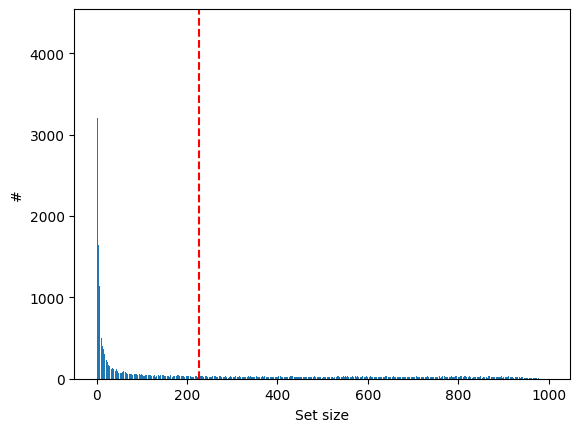

In [228]:
set_sizes_aps = np.unique(len_prediction_sets_aps, return_counts = True)
sizes_aps = set_sizes_aps[0]
size_frequencies_aps = set_sizes_aps[1]
avg_set_size_aps = (sizes_aps*size_frequencies_aps).sum() / size_frequencies_aps.sum()

plt.bar(sizes_aps, size_frequencies_aps)
plt.axvline(x = avg_set_size_aps, color = "red", linestyle = "--")
plt.xlabel("Set size")
plt.ylabel("#")
plt.savefig("APS_set_sizes")
print(f"The average set size of APS is {avg_set_size_aps}.")

In [229]:
# With randomisation
len_prediction_sets_aps_rand = prediction_sets_aps_rand.sum(axis = 1)

The average set size of APS (randomised) is 6.163285714285714.


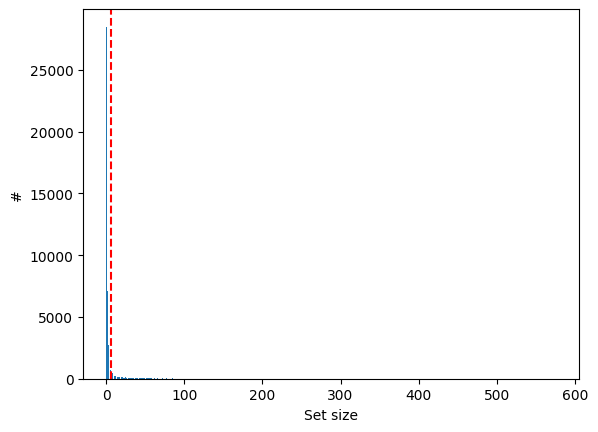

In [230]:
set_sizes_aps_rand = np.unique(len_prediction_sets_aps_rand, return_counts = True)
sizes_aps = set_sizes_aps_rand[0]
size_frequencies_aps = set_sizes_aps_rand[1]
avg_set_size_aps_rand = (sizes_aps*size_frequencies_aps).sum() / size_frequencies_aps.sum()

plt.bar(sizes_aps, size_frequencies_aps)
plt.axvline(x = avg_set_size_aps_rand, color = "red", linestyle = "--")
plt.xlabel("Set size")
plt.ylabel("#")
plt.savefig("APS_rand_set_sizes")
print(f"The average set size of APS (randomised) is {avg_set_size_aps_rand}.")

### Plot of Calibration Scores

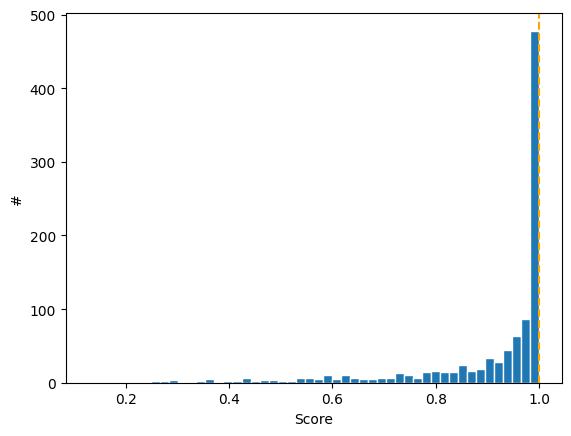

The conformal quantile q_hat is 0.9999182224273682.


In [231]:
# Without randomisation
plt.hist(cal_scores_aps, bins = 50, ec = "white")
plt.axvline(qhat_aps, color = "orange", linestyle = "--")
# plt.axvline(np.mean(cal_scores), color = "darkgreen")
# plt.text(10.1,0,'q_hat',rotation=90)
plt.xlabel("Score")
plt.ylabel("#")
plt.savefig("APS_cal_scores.png")
plt.show()

print(f"The conformal quantile q_hat is {qhat_aps}.")


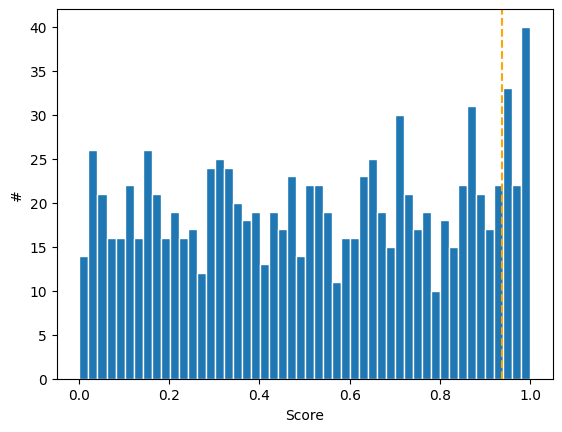

The conformal quantile q_hat is 0.9370679191260932.


In [232]:
# With randomisation

plt.hist(cal_scores_aps_rand, bins = 50, ec = "white")
plt.axvline(qhat_aps_rand, color = "orange", linestyle = "--")
# plt.axvline(np.mean(cal_scores), color = "darkgreen")
# plt.text(10.1,0,'q_hat',rotation=90)
plt.xlabel("Score")
plt.ylabel("#")
plt.savefig("APS_rand_cal_scores.png")
plt.show()

print(f"The conformal quantile q_hat is {qhat_aps_rand}.")

## Regularised Adaptive Prediction Sets (RAPS)

### Calibration Step and Construction of Prediction Sets (non-random and random)

In [233]:
# Problem setup
# Set RAPS regularization parameters (larger lam_reg and smaller k_reg leads to smaller sets)
lam_reg = 0.01
k_reg = 5
disallow_zero_sets = False # Set this to False in order to see the coverage upper bound hold
reg_vec = np.array(k_reg*[0,] + (smx.shape[1]-k_reg)*[lam_reg,])[None,:]

In [234]:
# Get scores. calib_X.shape[0] == calib_Y.shape[0] == n
cal_pi = cal_smx.argsort(1)[:,::-1];
cal_srt = np.take_along_axis(cal_smx,cal_pi,axis=1)
cal_srt_reg = cal_srt + reg_vec

cal_L = np.where(cal_pi == cal_labels[:,None])[1]

#non-random
cal_scores_raps = cal_srt_reg.cumsum(axis = 1)[np.arange(n), cal_L]
#random
cal_scores_raps_rand = cal_srt_reg.cumsum(axis=1)[np.arange(n),cal_L] - rng.uniform(0,1,n)*cal_srt_reg[np.arange(n),cal_L]

# Get the score quantile
#non-random
qhat_raps = np.quantile(cal_scores_raps, np.ceil((n+1)*(1-alpha))/n, method='higher')
#random
qhat_raps_rand = np.quantile(cal_scores_raps_rand, np.ceil((n+1)*(1-alpha))/n, method='higher')

# Deploy
n_val = val_smx.shape[0]
val_pi = val_smx.argsort(1)[:,::-1]
val_srt = np.take_along_axis(val_smx,val_pi,axis=1)
val_srt_reg = val_srt + reg_vec
val_srt_reg_cumsum = val_srt_reg.cumsum(axis=1)


#non_random
indicators_raps = val_srt_reg.cumsum(axis=1) - val_srt_reg <= qhat_raps
#random
indicators_raps_rand = (val_srt_reg.cumsum(axis=1) -  rng.uniform(0,1,(n_val,1))*val_srt_reg) <= qhat_raps_rand


In [235]:
if disallow_zero_sets:
  indicators_raps[:,0] = True
  indicators_raps_rand[:,0] = True
prediction_sets_raps = np.take_along_axis(indicators_raps,val_pi.argsort(axis=1),axis=1)
prediction_sets_raps_rand = np.take_along_axis(indicators_raps_rand,val_pi.argsort(axis=1),axis=1)

### Coverage (given the sampled calibration data)

In [236]:
empirical_coverage_raps = prediction_sets_raps[
    np.arange(prediction_sets_raps.shape[0]), val_labels
].mean()
print(f"The empirical coverage is: {empirical_coverage_raps}")

The empirical coverage is: 0.9677551020408163


In [237]:
empirical_coverage_raps_rand = prediction_sets_raps_rand[
    np.arange(prediction_sets_raps_rand.shape[0]), val_labels
].mean()
print(f"The empirical coverage is: {empirical_coverage_raps_rand}")

The empirical coverage is: 0.8993877551020408


### Plot of Set Sizes


In [238]:
# Without randomisation
len_prediction_sets_raps = prediction_sets_raps.sum(axis = 1)

The average set size of RAPS is 6.85869387755102.


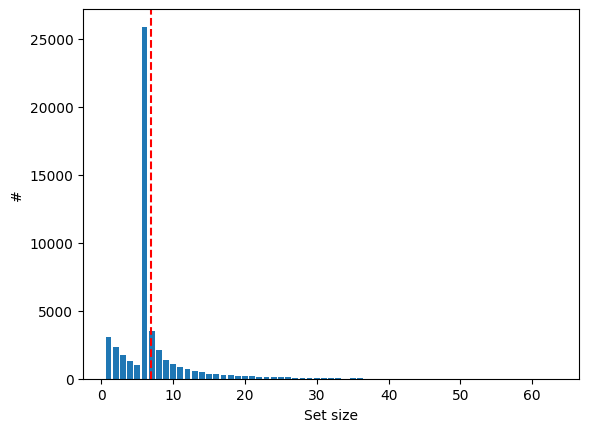

In [239]:
set_sizes_raps = np.unique(len_prediction_sets_raps, return_counts = True)
sizes_raps = set_sizes_raps[0]
size_frequencies_raps = set_sizes_raps[1]
avg_set_size_raps = (sizes_raps*size_frequencies_raps).sum() / size_frequencies_raps.sum()
plt.bar(sizes_raps, size_frequencies_raps)
plt.axvline(x = avg_set_size_raps, color = "red", linestyle = "--")
plt.xlabel("Set size")
plt.ylabel("#")
plt.savefig("RAPS_set_sizes")

print(f"The average set size of RAPS is {avg_set_size_raps}.")

In [240]:
# With randomisation
len_prediction_sets_raps_rand = prediction_sets_raps_rand.sum(axis = 1)

The average set size of RAPS (randomised) is 3.0086326530612246.


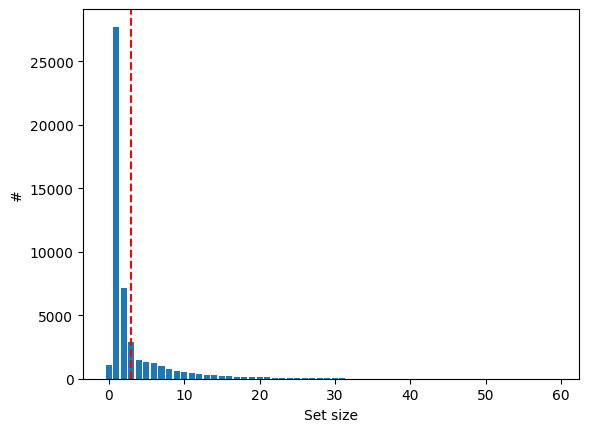

In [241]:
set_sizes_raps_rand = np.unique(len_prediction_sets_raps_rand, return_counts = True)
sizes_raps = set_sizes_raps_rand[0]
size_frequencies_raps = set_sizes_raps_rand[1]
avg_set_size_raps = (sizes_raps*size_frequencies_raps).sum() / size_frequencies_raps.sum()
plt.bar(sizes_raps, size_frequencies_raps)
plt.axvline(x = avg_set_size_raps, color = "red", linestyle = "--")
plt.xlabel("Set size")
plt.ylabel("#")
plt.savefig("RAPS_rand_set_sizes")

print(f"The average set size of RAPS (randomised) is {avg_set_size_raps}.")

### Plot of calibration scores

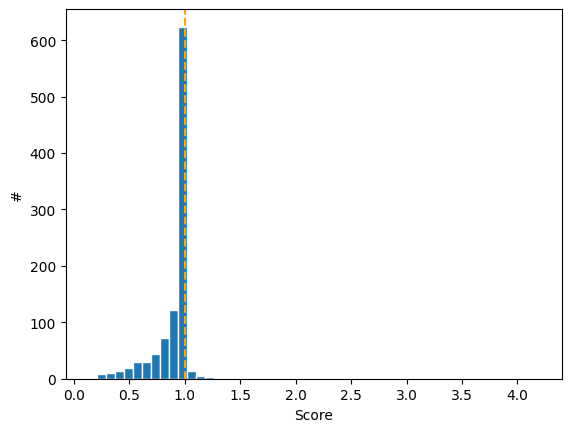

The conformal quantile q_hat is 0.9999680519104004.


In [242]:
# Without randomisation
plt.hist(cal_scores_raps, bins = 50, ec = "white")
plt.axvline(qhat_raps, color = "orange", linestyle = "--")
# plt.axvline(np.mean(cal_scores), color = "darkgreen")
plt.xlabel("Score")
plt.ylabel("#")
plt.savefig("RAPS_cal_scores.png")
plt.show()
print(f"The conformal quantile q_hat is {qhat_raps}.")

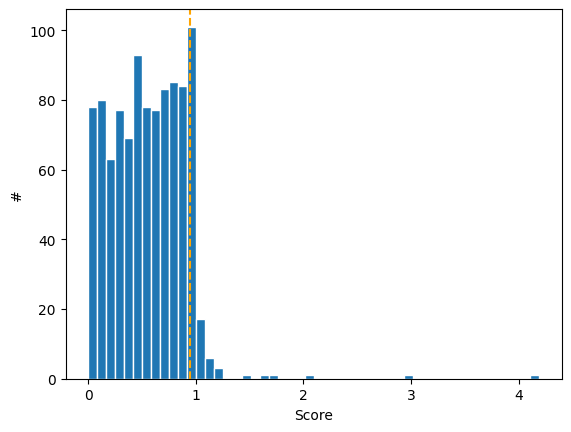

The conformal quantile q_hat is 0.9480747258473499.


In [243]:
# Without randomisation
plt.hist(cal_scores_raps_rand, bins = 50, ec = "white")
plt.axvline(qhat_raps_rand, color = "orange", linestyle = "--")
# plt.axvline(np.mean(cal_scores), color = "darkgreen")
plt.xlabel("Score")
plt.ylabel("#")
plt.savefig("RAPS_rand_cal_scores.png")
plt.show()
print(f"The conformal quantile q_hat is {qhat_raps_rand}.")

## Building an example

### prediction_set_image

In [244]:
import numpy.typing as npt

# prediction_set_image
# This function takes an image index and softmax scores, performs different methods of prediction set generation,
# and prints information about the predicted class, true label, and optionally displays the image.
#
# inputs:
# img_index: int - Index of the image in the dataset
# smx: npt.ArrayLike - Softmax scores for various classes
# method: str - Method for generating prediction set ("sm", "aps", "raps")
# random: bool - Whether to introduce randomness in the set (default: False)
# disallow_zero_sets: bool - Whether to disallow zero-sized prediction sets (default: False)
# print_img: bool - Whether to display the image (default: False)
#
# outputs: None - Prints prediction set and other information

def prediction_set_image(img_index: int, smx: npt.ArrayLike, method: str, random=False, disallow_zero_sets=False, print_img=False):

    if print_img:
        # Print predicted class and true label
        ex_max_prob = smx[img_index].argmax()
        print(label_strings[ex_max_prob])
        ex_true_lab = labels[img_index]
        print(label_strings[ex_true_lab])

        # Load and display the image
        img = imread(f'../data/imagenet/examples/{img_index}.jpeg')
        plt.imshow(img)

    # Generate prediction set based on the specified method
    if method == "sm":
        prediction_set = smx[img_index] > 1 - qhat_sm
    elif method == "aps":
        _smx = smx[img_index]
        _pi = np.argsort(_smx)[::-1]
        _srt = np.take_along_axis(_smx, _pi, axis=0)
        _srt_cumsum = _srt.cumsum()
        _ind = (_srt_cumsum - np.random.rand() * _srt) <= qhat_aps_rand if random else _srt_cumsum - _srt <= qhat_aps

        if disallow_zero_sets:
            _ind[0] = True
        prediction_set = np.take_along_axis(_ind, _pi.argsort(), axis=0)

    elif method == "raps":
        _smx = smx[img_index]
        _pi = np.argsort(_smx)[::-1]
        _srt = np.take_along_axis(_smx, _pi, axis=0)
        _srt_reg = _srt + reg_vec.squeeze()
        _srt_reg_cumsum = _srt_reg.cumsum()
        _ind = (_srt_reg_cumsum - np.random.rand() * _srt_reg) <= qhat_raps_rand if random else _srt_reg_cumsum - _srt_reg <= qhat_raps

        if disallow_zero_sets:
            _ind[0] = True
        prediction_set = np.take_along_axis(_ind, _pi.argsort(), axis=0)

    # Print the generated prediction set
    print(f"The prediction set is: {list(label_strings[prediction_set])}")
    return prediction_set


### Hard Difficulty

In [245]:
# Identify "hard" examples as those with large prediction sets (>10) and check which ones are loaded
val_idx = np.where(idx == False)[0]
np.unique(prediction_sets_raps.sum(axis = 1), return_counts = True)

# Find indices of examples with large sets
idx_hard_examples = val_idx[np.where(prediction_sets_raps_rand.sum(axis = 1) > 10)[0]]

# Check the correponding pictures are loaded
idx_avail = np.isin(idx_hard_examples, example_idx)
idx_hard_and_avail = idx_hard_examples[idx_avail]
idx_hard_and_avail # hard and available samples for display

array([  112,  1059, 11667, 18126, 18331, 22735, 23520, 24023, 25729,
       29283, 29326, 32759, 33825, 33903, 34029, 37193, 38080, 38393,
       39216, 39222, 40202, 40414, 40484, 42074, 42469, 43134, 46420,
       46444, 48807, 48916])

In [246]:
idx_hard_and_avail[0] # 112

112

The prediction set is: ['great white shark', 'pillow', 'totem pole']
The prediction set is: ['tench', 'goldfish', 'great white shark', 'tiger shark', 'hammerhead shark', 'electric ray', 'stingray', 'cock', 'goldfinch', 'house finch', 'junco', 'American robin', 'bulbul', 'jay', 'chickadee', 'American dipper', 'kite', 'bald eagle', 'vulture', 'great grey owl', 'newt', 'spotted salamander', 'axolotl', 'American bullfrog', 'tree frog', 'tailed frog', 'loggerhead sea turtle', 'leatherback sea turtle', 'banded gecko', 'green iguana', 'Carolina anole', 'desert grassland whiptail lizard', 'alligator lizard', 'European green lizard', 'Nile crocodile', 'American alligator', 'triceratops', 'smooth green snake', 'kingsnake', 'garter snake', 'water snake', 'vine snake', 'night snake', 'boa constrictor', 'African rock python', 'Indian cobra', 'green mamba', 'trilobite', 'scorpion', 'yellow garden spider', 'barn spider', 'European garden spider', 'tarantula', 'wolf spider', 'tick', 'centipede', 'blac

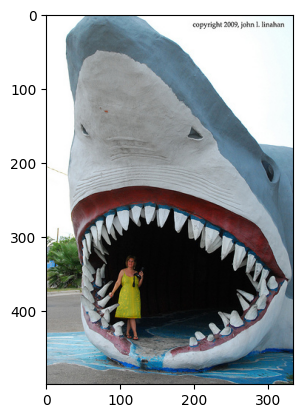

In [247]:
hard_sm = prediction_set_image(smx = smx, method = "sm", img_index = 112, random = False, print_img = False)
hard_aps = prediction_set_image(smx = smx, method = "aps", img_index = 112, random = False, print_img = False)
hard_aps_rand = prediction_set_image(smx = smx, method = "aps", img_index = 112, random = True, print_img = False)
hard_raps = prediction_set_image(smx = smx, method = "raps", img_index = 112, random = False, print_img = True)
hard_raps_rand = prediction_set_image(smx = smx, method = "raps", img_index = 112, random = True, print_img = False)

In [248]:
# Set sizes
print(hard_sm.sum(), hard_aps.sum(), hard_aps_rand.sum(), hard_raps.sum(), hard_raps_rand.sum())

3 864 40 17 14


### Medium Difficulty

In [249]:
np.unique(prediction_sets_raps.sum(axis = 1), return_counts = True)

# Find indices of examples with large sets
idx_medium_examples = val_idx[np.where((4 <= prediction_sets_raps_rand.sum(axis = 1)) &( prediction_sets_raps_rand.sum(axis = 1) <= 7))[0]]

# Check the correponding pictures are loaded
idx_avail = np.isin(idx_medium_examples, example_idx)
idx_medium_and_avail = idx_medium_examples[idx_avail]
idx_medium_and_avail # hard and available samples for display

array([  646,  2418,  2610,  2795,  3693,  5308,  6241,  7621, 10065,
       10098, 11200, 13577, 13890, 14681, 15186, 17301, 19040, 19957,
       23024, 23218, 23503, 23886, 24012, 24924, 25037, 25813, 26058,
       26373, 26392, 28119, 29109, 31567, 32115, 33876, 34963, 35133,
       35469, 38804, 39718, 40793, 42015, 43204, 43249, 46193, 47408,
       48208, 48476, 48618, 49010])

In [250]:
idx_medium_and_avail[2] #2795

2610

smooth green snake
smooth green snake
The prediction set is: ['European green lizard', 'smooth green snake', 'vine snake', 'green mamba']
The prediction set is: ['tench', 'goldfish', 'great white shark', 'cock', 'hen', 'brambling', 'goldfinch', 'house finch', 'junco', 'indigo bunting', 'American robin', 'bulbul', 'jay', 'magpie', 'chickadee', 'bald eagle', 'fire salamander', 'smooth newt', 'newt', 'spotted salamander', 'axolotl', 'American bullfrog', 'tree frog', 'tailed frog', 'mud turtle', 'terrapin', 'box turtle', 'banded gecko', 'green iguana', 'Carolina anole', 'desert grassland whiptail lizard', 'agama', 'frilled-necked lizard', 'alligator lizard', 'Gila monster', 'European green lizard', 'chameleon', 'Komodo dragon', 'Nile crocodile', 'American alligator', 'worm snake', 'ring-necked snake', 'eastern hog-nosed snake', 'smooth green snake', 'kingsnake', 'garter snake', 'water snake', 'vine snake', 'night snake', 'boa constrictor', 'African rock python', 'Indian cobra', 'green mamb

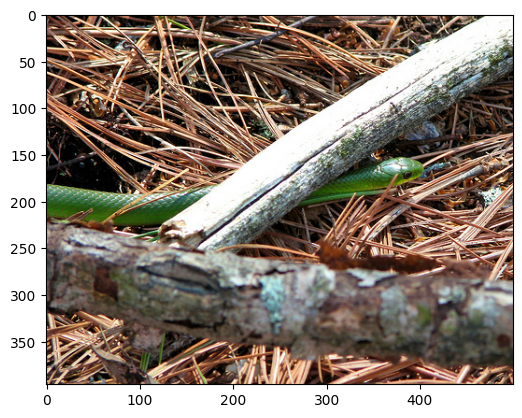

In [251]:
medium_sm = prediction_set_image(smx = smx, method = "sm", img_index = 2795, print_img = True)
medium_aps = prediction_set_image(smx = smx, method = "aps", img_index = 2795, random = False, print_img = False)
medium_aps_rand = prediction_set_image(smx = smx, method = "aps", img_index = 2795, random = True, print_img = False)
medium_raps = prediction_set_image(smx = smx, method = "raps", img_index = 2795, random = False, print_img = False)
medium_raps_rand = prediction_set_image(smx = smx, method = "raps", img_index = 2795, random = True, print_img = False)

In [252]:
print(medium_sm.sum(), medium_aps.sum(), medium_aps_rand.sum(), medium_raps.sum(), medium_raps_rand.sum())

4 513 9 11 7


### Easy Difficulty

In [253]:
np.unique(prediction_sets_raps.sum(axis = 1), return_counts = True)

# Find indices of examples with large sets
idx_easy_examples = val_idx[np.where(prediction_sets_raps_rand.sum(axis = 1) < 3)[0]]

# Check the correponding pictures are loaded
idx_avail = np.isin(idx_easy_examples, example_idx)
idx_easy_and_avail = idx_easy_examples[idx_avail]
# idx_easy_and_avail # hard and available samples for display

In [254]:
idx_easy_and_avail[-6] #49034

49034

In [255]:
easy_sm = prediction_set_image(smx = smx, method = "sm", img_index = 49034, random = False, print_img = False)
easy_aps = prediction_set_image(smx = smx, method = "aps", img_index = 49034, random = False, print_img = False)
easy_aps_rand = prediction_set_image(smx = smx, method = "aps", img_index = 49034, random = True, print_img = False)
easy_raps = prediction_set_image(smx = smx, method = "raps", img_index = 49034, random = False, print_img = False)
easy_raps_rand = prediction_set_image(smx = smx, method = "raps", img_index = 49034, random = True, print_img = False)

The prediction set is: ['volcano']
The prediction set is: ['tent', 'wing', 'yurt', 'alp', 'geyser', 'lakeshore', 'shoal', 'volcano']
The prediction set is: []
The prediction set is: ['tent', 'yurt', 'alp', 'geyser', 'lakeshore', 'volcano']
The prediction set is: ['volcano']


In [256]:
# set sizes
print(easy_sm.sum(), easy_aps.sum(), easy_aps_rand.sum(), easy_raps.sum(), easy_raps_rand.sum())

1 8 0 6 1


## Checking Coverage

0.9614784568548203
0.9071224489795918
[42213 37677 31222 13836  1663 44946 44627 16524 47310 43400]
0.939267136156559
0.8902244897959184
[47504  1294 35318  3449 36556 19300  1974  1177 49716 43058]
0.9547105841338634
0.9013673469387755
[40955 30185 43233 30719 43855 18920 43327 15965 32903 27953]
0.9549770727753639
0.9016530612244898
[35372 37891 42833  4858 21959 12583 37025 42634  5955 27290]
0.9573331512510777
0.9034081632653062
[ 6134 20760 28262 41368 15363  3800 28142 18331   521 42693]
0.9566717445850372
0.9028979591836734
[41066 13774 13471 17384 22038  6977 41642 19859 31181 24833]
0.9616893045604229
0.9072857142857143
[20425 15279  5676 36803 22163 26511 44802 40397 47595 40470]
0.9757768381386995
0.921530612244898
[41634 20885 42735 15484  8866 15718 28442 46190 19310  9204]
0.952354971319437
0.8997755102040816
[10445 15772 49746  6066  3281 45145 14237 29026 31816 47710]
0.957116112112999
0.9032653061224489
[ 5540 22475 39774 21566 14339 19827 39663 40528 25062 19859]
0.94

(array([ 5.,  4., 10., 17., 17., 14., 15., 12.,  3.,  3.]),
 array([0.88061224, 0.88492653, 0.88924082, 0.8935551 , 0.89786939,
        0.90218367, 0.90649796, 0.91081224, 0.91512653, 0.91944082,
        0.9237551 ]),
 <BarContainer object of 10 artists>)

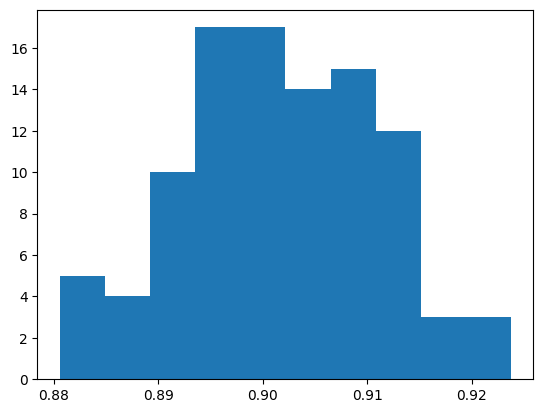

In [257]:

scores = 1 - smx

indices_eval = np.arange(50000)
R = 100
n = 1000
alpha = 0.1
coverages = np.zeros((R,))
for r in range(R):
  rng.shuffle(indices_eval) # shuffle

  calib_scores, val_scores = (scores[indices_eval[:n]],scores[indices_eval[n:]]) # split
  calib_labels = labels[indices_eval[:n]]
  valid_labels = labels[indices_eval[n:]]

  qhat = np.quantile(calib_scores[np.arange(1000), calib_labels], np.ceil((n+1)*(1-alpha))/n, method='higher') # calibrate

  pred_sets = (val_scores <= qhat)
  coverages[r] = pred_sets[
      np.arange(val_scores.shape[0]), valid_labels
   ].mean()
  if r % 5 == 0:
    print(qhat)
    print(coverages[r])
    print(indices_eval[:10])
average_coverage = coverages.mean() # should be close to 1-alpha
plt.hist(coverages)

## Checking Conditional Coverage

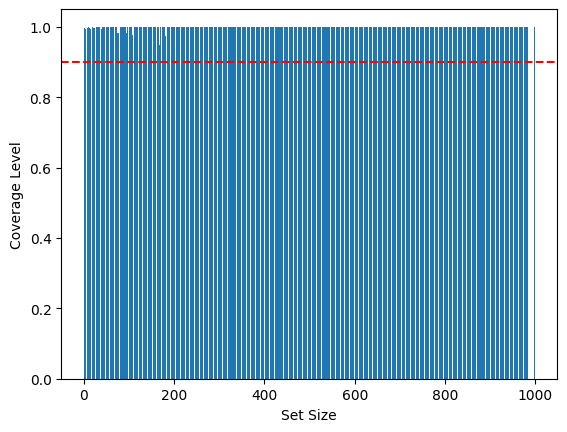

In [258]:
# extract the various set sizes
possible_set_sizes_aps = np.unique(len_prediction_sets_aps)
# apply the grouping structure to the data
list_indices_aps = [np.where(len_prediction_sets_aps == i)[0] for i in possible_set_sizes_aps]
# compute the coverage conditional on the set sizes
cond_coverage_aps = [prediction_sets_aps[i, val_labels[i]].mean() for i in list_indices_aps]

plt.bar(possible_set_sizes_aps, cond_coverage_aps)
plt.axhline(y = 0.9, color = "red", linestyle = "--")
plt.xlabel("Set Size")
plt.ylabel("Coverage Level")
plt.savefig("cond_coverage_aps")

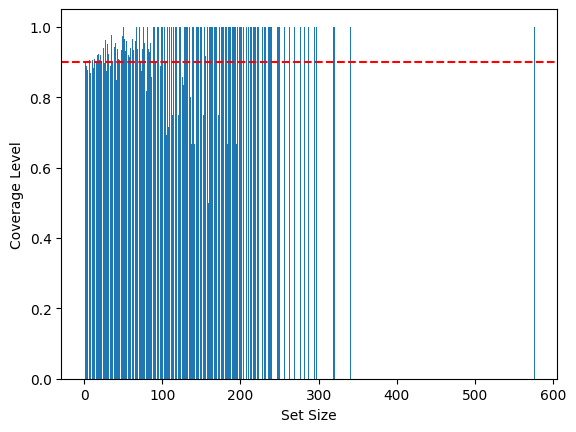

In [259]:
possible_set_sizes_aps_rand = np.unique(len_prediction_sets_aps_rand)
list_indices_aps_rand = [np.where(len_prediction_sets_aps_rand == i)[0] for i in possible_set_sizes_aps_rand]
cond_coverage_aps_rand = [prediction_sets_aps_rand[i, val_labels[i]].mean() for i in list_indices_aps_rand]
plt.bar(possible_set_sizes_aps_rand, cond_coverage_aps_rand)
plt.axhline(y = 0.9, color = "red", linestyle = "--")
plt.xlabel("Set Size")
plt.ylabel("Coverage Level")
plt.savefig("cond_coverage_aps_rand")

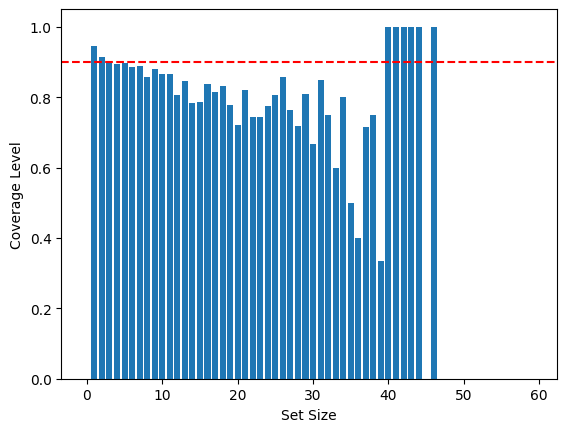

In [260]:
possible_set_sizes_raps_rand = np.unique(len_prediction_sets_raps_rand)
list_indices_raps_rand = [np.where(len_prediction_sets_raps_rand == i)[0] for i in possible_set_sizes_raps_rand]
cond_coverage_raps_rand = [prediction_sets_raps_rand[i, val_labels[i]].mean() for i in list_indices_raps_rand]
plt.bar(possible_set_sizes_raps_rand, cond_coverage_raps_rand)

plt.axhline(y = 0.9, color = "red", linestyle = "--")
plt.xlabel("Set Size")
plt.ylabel("Coverage Level")
plt.savefig("cond_coverage_raps_rand")

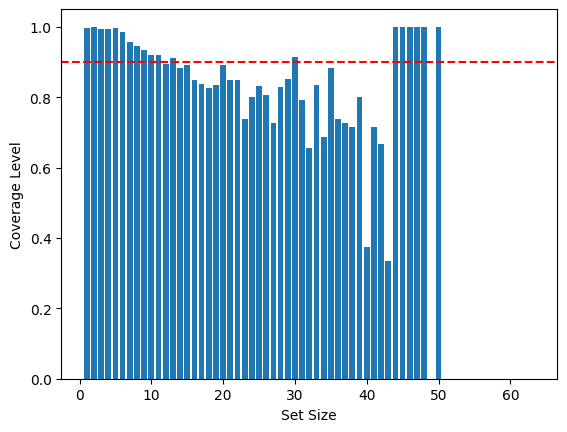

In [261]:
possible_set_sizes_raps = np.unique(len_prediction_sets_raps)
list_indices_raps = [np.where(len_prediction_sets_raps == i)[0] for i in possible_set_sizes_raps]
cond_coverage_raps = [prediction_sets_raps[i, val_labels[i]].mean() for i in list_indices_raps]
plt.bar(possible_set_sizes_raps, cond_coverage_raps)
plt.axhline(y = 0.9, color = "red", linestyle = "--")
plt.xlabel("Set Size")
plt.ylabel("Coverage Level")
plt.savefig("cond_coverage_raps")

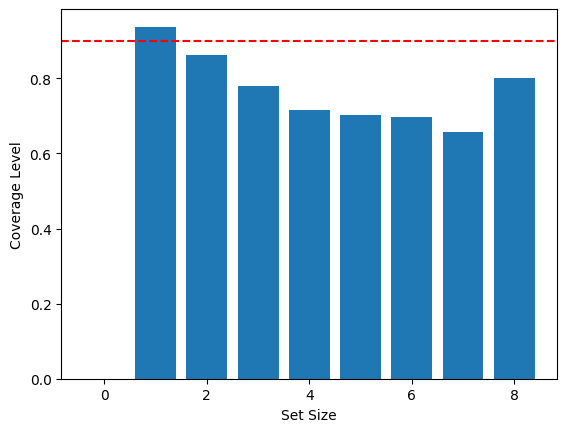

In [262]:
possible_set_sizes_sm = np.unique(len_prediction_sets_sm)
list_indices_sm = [np.where(len_prediction_sets_sm == i)[0] for i in possible_set_sizes_sm]
cond_coverage_sm = [prediction_sets_sm[i, val_labels[i]].mean() for i in list_indices_sm]
plt.bar(possible_set_sizes_sm, cond_coverage_sm)
plt.axhline(y = 0.9, color = "red", linestyle = "--")
plt.xlabel("Set Size")
plt.ylabel("Coverage Level")
plt.savefig("cond_coverage_sm")